In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt
import desisky
from desisky.io import load_builtin
from desisky.data import SkySpecVAC
from desisky.training import NumpyLoader
from desisky.models.vae import make_SkyVAE
import equinox as eqx
import optax 
import torch 
from torch.utils.data import random_split
import os
import json 
import sys

In [2]:
# Load the pretrained VAE
vae, meta = load_builtin("vae")

print("VAE Architecture:")
print(f"  Input channels: {meta['arch']['in_channels']}")
print(f"  Latent dimension: {meta['arch']['latent_dim']}")
print(f"\nModel schema version: {meta['schema']}")

# Load in an uninitialized VAE
new_vae = make_SkyVAE(in_channels=7781, latent_dim=8, key=jax.random.PRNGKey(32))
print(new_vae)

VAE Architecture:
  Input channels: 7781
  Latent dimension: 8

Model schema version: 0
SkyVAE(
  in_channels=7781,
  latent_dim=8,
  common_fc=Sequential(
    layers=(
      Linear(
        weight=f32[1000,7781],
        bias=f32[1000],
        in_features=7781,
        out_features=1000,
        use_bias=True
      ),
      Lambda(fn=<PjitFunction of <function relu at 0x7f986cbc23e0>>),
      Linear(
        weight=f32[800,1000],
        bias=f32[800],
        in_features=1000,
        out_features=800,
        use_bias=True
      ),
      Lambda(fn=<PjitFunction of <function relu at 0x7f986cbc23e0>>),
      Linear(
        weight=f32[600,800],
        bias=f32[600],
        in_features=800,
        out_features=600,
        use_bias=True
      ),
      Lambda(fn=<PjitFunction of <function relu at 0x7f986cbc23e0>>),
      Linear(
        weight=f32[500,600],
        bias=f32[500],
        in_features=600,
        out_features=500,
        use_bias=True
      ),
      Lambda(fn=<PjitF

In [3]:
# Load the sky spectra value-added catalog
vac = SkySpecVAC(version='v1.0', download=True)
wavelength, flux, metadata = vac.load()

print(f"Loaded {flux.shape[0]} sky spectra")
print(f"Wavelength range: {wavelength.min():.1f} - {wavelength.max():.1f} Å")
print(f"Spectrum shape: {flux.shape}")
print(f"Flux range: {flux.min():.6f} - {flux.max():.6f}")
print(f"Flux mean: {flux.mean():.6f}, std: {flux.std():.6f}")

# Create the training/test split
dataset_size = len(flux)
train_size = int(0.9 * dataset_size)
test_size = dataset_size - train_size

gen = torch.Generator().manual_seed(32)
train_set, test_set = random_split(flux, [train_size, test_size], generator=gen)
print(f"Training set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")

# Create data loaders
batch_size = 128

train_loader = NumpyLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True
)

test_loader = NumpyLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=False
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Loaded 9176 sky spectra
Wavelength range: 3600.0 - 9824.0 Å
Spectrum shape: (9176, 7781)
Flux range: -49.059757 - 504.074097
Flux mean: 3.130227, std: 6.225298
Training set size: 8258
Test set size: 918
Number of training batches: 65
Number of test batches: 8


In [4]:
def get_base_dir() -> str:
    """
    Determine base directory of the project. This function checks if the
    code is running w/in Jupyter notebooks or as standalone scripts.

    Returns:
        str: Absolute path of the base dir.
    """
    # Check if running in a Jupyter notebook
    if 'ipykernel' in sys.modules:
        # Assuming notebooks are in the 'notebooks' folder, move one folder up to get base dir.
        return os.path.abspath(os.path.join(os.getcwd(), ".."))
    else:
        # Get the dir of current script and move one folder up to base dir.
        return os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))

def save(filename: str, project_name: str, hyperparams: 'Any', model: 'Any') -> None:
    """
    Save the model along with hyperparameters to a specified file.

    Args:
        filename (str): The name of the file to save the model to.
        project_name (str): The name of the directory that these saveds models will be stored in.
        hyperparams (Dict[str, Any]): Hyperparameters to save along with the model.
        model (Any): The model to save.

    Returns:
        None
    """
    # Fetch the base directory
    base_dir = get_base_dir()
    
    # Determine the full path where models should be saved
    save_directory = os.path.join(base_dir, 'saved_models', str(project_name))
    
    # Ensure the directory exists; if not, create it.
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    
    # Construct the full path to save the model
    full_path = os.path.join(save_directory, filename)

    # Save the model and hyperparameters
    with open(full_path, "wb") as f:
        hyperparam_str = json.dumps(hyperparams)
        f.write((hyperparam_str + "\n").encode())
        eqx.tree_serialise_leaves(f, model)

def get_hyperparams_for_model(model):
    """
    Extracts the hyperparameters from the model.

    Args:
        model (eqx.Module):
            Model to extract hyperparameters.
    
    Returns:
        dict: A dictionary of hyperparams.
    """
    # Assume this is the simple VAE
    return {
        'in_channels': model.in_channels,
        'latent_dim': model.latent_dim
    }

def load_model(filename: str, project_name: str) -> "Any":
    """
    Load a model along with its hyperparameters from a specified file.

    Args:
        filename (str): The name of the file from which to load the model.

    Returns:
        Any: The deserialized model instance.
    """
    # Fetch base directory path
    base_dir = get_base_dir()

    # Determine directory where the model is saved
    save_directory = os.path.join(base_dir, 'saved_models/' + str(project_name))

    # Create the directory if it doesn't exist
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # Construct the full path from where to load the model
    full_path = os.path.join(save_directory, filename+".eqx")

    # Open the file in binary read mode and load the hyperparameters and model
    with open(full_path, "rb") as f:
        hyperparams = json.loads(f.readline().decode())
        model = make_SkyVAE(**hyperparams)
        return eqx.tree_deserialise_leaves(f, model)

In [5]:
# utils.py  (or wherever you keep helpers)
def default_kernel_sigma(latent_dim: int) -> float:
    """
    Heuristic bandwidth for the RBF kernel, σ = √(2 / d),
    recommended by Zhao et al.'s tutorial code.
    """
    return (2.0 / float(latent_dim)) ** 0.5

def _rbf_kernel(x, y, *, sigma=1.0):
    """
    Isotropic RBF kernel ‖x-y‖² / (2σ²) – works on batched 2-D arrays.
    """
    x2 = jnp.sum(x * x, axis=1, keepdims=True)
    y2 = jnp.sum(y * y, axis=1, keepdims=True)
    cross = jnp.dot(x, y.T)
    # ‖x‖² + ‖y‖² – 2 x⋅y
    dist2 = x2 + y2.T - 2.0 * cross
    k = jnp.exp(-dist2 / (2.0 * sigma ** 2))
    return k

def mmd_rbf_biased(x, y, *, sigma=1.0):
    xx = _rbf_kernel(x, x, sigma=sigma).mean()
    yy = _rbf_kernel(y, y, sigma=sigma).mean()
    xy = _rbf_kernel(x, y, sigma=sigma).mean()
    return xx + yy - 2 * xy      #  ≥ 0


def loss_fn(model: eqx.Module,
            x: jnp.ndarray,
            key: jax.random.PRNGKey,
            *,
            beta: float = 1.0,                 # (1-α) in InfoVAE
            lam: float = 10.0,                 # λ in InfoVAE
            kernel_sigma: float | str = "auto"): # bandwidth or "auto")
    """
    InfoVAE-MMD objective:
        L = recon_loss  +  beta * KL[q(z|x) || p(z)]
                         +  lam  * MMD[q(z) , p(z)]
    """

    # ── 0. choose σ heuristically if requested ────────────────────────
    if kernel_sigma is None or kernel_sigma == "auto":
        kernel_sigma = default_kernel_sigma(model.latent_dim)

    # ── 1. forward pass ───────────────────────────────────────────────
    # x.shape = (B, L) where B=batch_size, L=7781
    
    ## Encode the input
    mean, logvar = jax.vmap(model.encode)(x)  # (B, latent_dim)
    
    ## Sample from the latent space
    # FIX: Need to vmap sample() to give each sample its own random key
    batch_size = x.shape[0]
    keys = jax.random.split(key, batch_size)  # Create batch_size unique keys
    z = jax.vmap(model.sample)(mean, logvar, keys)  # Vmap over all 3 args
    
    ## Decode the latent representation
    out_recon = jax.vmap(model.decode)(z)

    # reconstruction (L2/MSE)
    recon_loss = jnp.mean(optax.l2_loss(out_recon, x))

    # KL[q(z|x) ‖ p(z)] per-sample, then mean over batch
    kl_loss = -0.5 * jnp.mean(1 + logvar - jnp.square(mean) - jnp.exp(logvar))

    # MMD between aggregated posterior q(z) and prior p(z) = N(0,I)
    z_prior = jax.random.normal(key, shape=z.shape)     # same shape
    mmd_loss = mmd_rbf_biased(z, z_prior, sigma=kernel_sigma)

    total = recon_loss + beta * kl_loss + (lam - beta) * mmd_loss
    aux = dict(
        recon = recon_loss,
        kl_weighted = beta * kl_loss,
        mmd_weighted = (lam - beta) * mmd_loss,
        loss_z = beta * kl_loss + (lam - beta) * mmd_loss
    )

    return total, aux

In [6]:
def train(model,
          train_loader,
          test_loader,
          optim,
          *,
          n_epochs: int,
          beta: float,
          lam: float,
          kernel_sigma: float | str):
    
    # Train the arrays in our model, filtering out everything else (e.g. activations)
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    # Initialize a variable to track the best train loss
    best_train_loss = float('inf')

    # Always wrap everything: computing gradients, running optimizer, and 
    # updating the model into a single JIT region. This ensures things run
    # as fast as possible.
    @eqx.filter_jit
    def make_step(model, x, opt_state, beta, lam, kernel_sigma, key):
        # Compute the gradients
        (loss, aux), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(
                                                         model,
                                                         x=x,
                                                         key=key, 
                                                         beta=beta,
                                                         lam=lam,
                                                         kernel_sigma=kernel_sigma)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss, aux
    
    key_seed = 0
    train_losses = []
    # Loop over every epoch
    for epoch in range(1, n_epochs+1):
        # Total, recon, weighted KL, weighted MMD, n samples
        epoch_train_loss, rec, klw, mmdw, loss_z, batch_count = 0.0, 0.0, 0.0, 0.0, 0.0, 0

        for step, (x) in enumerate(train_loader):
            # Update keys for every batch, so that we are
            # getting different noise values.
            key_seed += 1  # <- FIX: Increment the key seed!
            # Loss computation & parameter update
            model, opt_state, train_loss, aux = make_step(model=model,
                                                     x=x,  # <- FIX: Use x directly
                                                     key=jax.random.PRNGKey(key_seed),
                                                     beta=beta,
                                                     lam=lam,
                                                     kernel_sigma=kernel_sigma,
                                                     opt_state=opt_state)
            epoch_train_loss += float(train_loss)
            batch_count += 1

        epoch_train_loss /= batch_count            
            # # Convert to Python floats and accumulate
            # loss_f = float(train_loss)
            # recon_f = float(aux["recon"])
            # kl_f = float(aux["kl_weighted"])
            # mmd_f = float(aux["mmd_weighted"])
            # loss_z_f = float(aux["loss_z"])
            
        # epoch-averaged losses
        train_losses.append(epoch_train_loss)
        # Check if current loss is best loss
        if epoch_train_loss < best_train_loss:
            # Update the best training loss
            best_train_loss = epoch_train_loss
            # Save the model at the end of each epoch
            hyperparams = get_hyperparams_for_model(model)
            # save(
            #     filename="vae1.eqx",
            #     project_name=str(project_name),
            #     hyperparams=hyperparams,
            #     model=model
            # )

        if epoch % 1 == 0:   
            print(f"epoch {epoch}, train loss: {epoch_train_loss:.8f}")#, recon: {rec:.8f}, kl: {klw:.8f}, mmd: {mmdw:.8f}")

    return model, train_losses

In [ ]:
model = make_SkyVAE(in_channels=7781, latent_dim=8, key=jax.random.PRNGKey(32))

vac = SkySpecVAC(version='v1.0', download=True)
wavelength, flux, metadata = vac.load()

# Create the training/test split
dataset_size = len(flux)
train_size = int(0.9 * dataset_size)
test_size = dataset_size - train_size

gen = torch.Generator().manual_seed(32)
train_set, test_set = random_split(flux, [train_size, test_size], generator=gen)

# Create data loaders
batch_size = 128

train_loader = NumpyLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True
)

test_loader = NumpyLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=False
)

# FIX: Add gradient clipping to prevent NaN explosions
optim = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip gradients with norm > 1.0
    optax.adam(learning_rate=1e-4)
)

kernel_sigma = default_kernel_sigma(model.latent_dim)

In [8]:
# DEBUG: Test forward pass and loss computation
print("=== DEBUG: Testing forward pass ===")

# Get a single batch
test_batch = next(iter(train_loader))
print(f"Batch shape: {test_batch.shape}")
print(f"Batch min: {test_batch.min():.4f}, max: {test_batch.max():.4f}, mean: {test_batch.mean():.4f}")

# Test encode
print("\n1. Testing encode...")
mean, logvar = jax.vmap(model.encode)(test_batch)
print(f"   Mean shape: {mean.shape}, range: [{mean.min():.4f}, {mean.max():.4f}]")
print(f"   Logvar shape: {logvar.shape}, range: [{logvar.min():.4f}, {logvar.max():.4f}]")

# Test sample (with proper batching)
print("\n2. Testing sample...")
batch_size = test_batch.shape[0]
keys = jax.random.split(jax.random.PRNGKey(0), batch_size)
z = jax.vmap(model.sample)(mean, logvar, keys)
print(f"   Latent shape: {z.shape}, range: [{z.min():.4f}, {z.max():.4f}]")

# Test decode
print("\n3. Testing decode...")
out_recon = jax.vmap(model.decode)(z)
print(f"   Recon shape: {out_recon.shape}, range: [{out_recon.min():.4f}, {out_recon.max():.4f}]")

# Test loss
print("\n4. Testing loss computation...")
loss_val, aux = loss_fn(model, test_batch, jax.random.PRNGKey(0), beta=1e-3, lam=1, kernel_sigma=kernel_sigma)
print(f"   Total loss: {loss_val}")
print(f"   Recon: {aux['recon']}")
print(f"   KL weighted: {aux['kl_weighted']}")
print(f"   MMD weighted: {aux['mmd_weighted']}")

print("\n=== DEBUG COMPLETE ===")

=== DEBUG: Testing forward pass ===
Batch shape: (128, 7781)
Batch min: -0.2016, max: 386.4428, mean: 2.8165

1. Testing encode...
   Mean shape: (128, 8), range: [-0.2774, 0.2027]
   Logvar shape: (128, 8), range: [-0.2045, 0.3213]

2. Testing sample...
   Latent shape: (128, 8), range: [-3.5655, 3.1428]

3. Testing decode...
   Recon shape: (128, 7781), range: [-0.0755, 0.0758]

4. Testing loss computation...
   Total loss: 22.4201602935791
   Recon: 22.40451431274414
   KL weighted: 2.695000330277253e-05
   MMD weighted: 0.015619147568941116

=== DEBUG COMPLETE ===


In [9]:
trained_model, train_loss = train(model=model,
          train_loader=train_loader,
          test_loader=test_loader,
          optim=optim,
          n_epochs=15,
          beta=1e-3,
          lam=4,
          kernel_sigma=kernel_sigma)

epoch 1, train loss: nan
epoch 2, train loss: nan
epoch 3, train loss: nan
epoch 4, train loss: nan
epoch 5, train loss: nan
epoch 6, train loss: nan
epoch 7, train loss: nan
epoch 8, train loss: nan
epoch 9, train loss: nan
epoch 10, train loss: nan
epoch 11, train loss: nan
epoch 12, train loss: nan
epoch 13, train loss: nan
epoch 14, train loss: nan
epoch 15, train loss: nan


ValueError: x and y must have same first dimension, but have shapes (30,) and (15,)

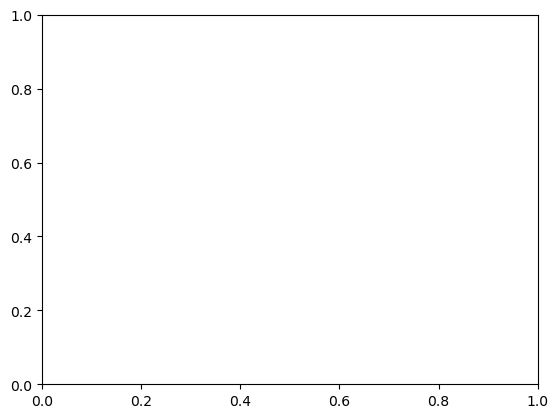

In [10]:
plt.plot(np.arange(30), train_loss)